<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-LCC/blob/main/Notebooks/07-TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Topic Detection</h1>

<h2>Topic Modelling</h1>

En esta notebook ahondaremos un poco más en la tarea de *Topic Modelling*. Para esto usaremos varias técnicas, algunas de ellas nuevas:

* Clustering en representaciones vectoriales de documentos.
* LDA. Implementación en [gensim](https://radimrehurek.com/gensim/models/ldamodel.html).
* LSA. Implementación en [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

Además, evaluaremos estas tareas usando métricas propias de la tarea.
* [Coherence](https://radimrehurek.com/gensim/models/coherencemodel.html): [source](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [2]:
!pip install -qq gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD

import spacy

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
!pip install -qq wordcloud

Consideraremos un corpus de 92579 documentos de texto, consisten en noticias de CNN. **Origen desconocido**

In [5]:
!gdown 1S-KYaCpb39vMphrkdnceXUkUhzHeapt7

Downloading...
From (original): https://drive.google.com/uc?id=1S-KYaCpb39vMphrkdnceXUkUhzHeapt7
From (redirected): https://drive.google.com/uc?id=1S-KYaCpb39vMphrkdnceXUkUhzHeapt7&confirm=t&uuid=43adb566-1a78-4ca6-9f74-53fb0b228406
To: /content/cnn_articles.txt
100% 365M/365M [00:04<00:00, 75.3MB/s]


In [6]:
with open('cnn_articles.txt', 'r', encoding='utf8') as f:
    articles = f.read().split('@delimiter')

print(len(articles))

cnn_df = pd.DataFrame({'document':articles})
cnn_df

92579


,document
0,-- Children in war-ravaged Afghanistan are sa...
1,"\n -- The Hard Rock Cafe franchise, famed for ..."
2,\nAn estimated 7 million people died due to ai...
3,\n -- A federal judge has temporarily blocked ...
4,"\n -- ""Terrorism and violence cannot be permis..."
...,...
92574,\n -- Pakistan's president has summoned the lo...
92575,\n -- The leader of one of the labs linked to ...
92576,\n -- The president of Florida A&M University ...
92577,"\nThis week, we mark the tenth anniversary of ..."


Nos quedamos solamente con los primeros 10000 artículos.

In [7]:
corpus = articles[:10000]

Exploremos los documentos, aquí podemos ver algunas palabras que podemos añadir a la lista de stopwords.

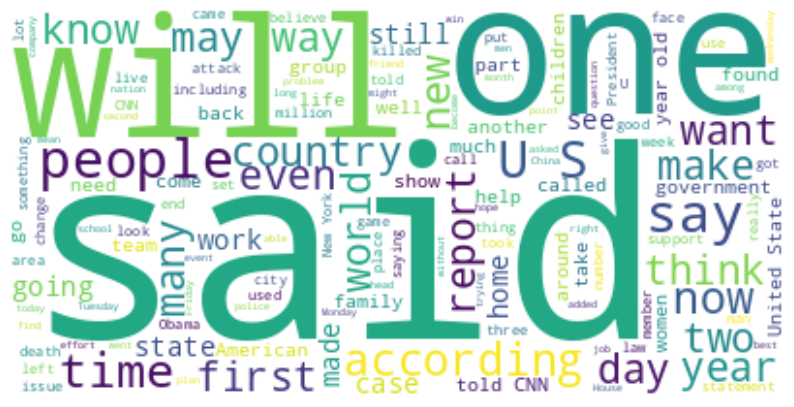

In [8]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=2000, contour_width=3, contour_color='steelblue')
wordcloud = wc.generate(" ".join(corpus))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Hacemos el preprocesamiento usando un pipeline *ligero* de scipy. Tarda alrededor de 40s.

In [9]:
%%time

nlp = spacy.blank('en')

tokenized_docs = [[t.text for t in tok_doc if
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha] for tok_doc in nlp.pipe(corpus) ]

CPU times: user 32.5 s, sys: 553 ms, total: 33 s
Wall time: 33.3 s


In [10]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['said'])

In [11]:
tokenized_docs = [[w for w in doc if w not in stopwords] for doc in tokenized_docs]

In [ ]:
print(tokenized_docs[0])

🛑 Si usamos un pipeline más completo podemos tardar hasta 12 minutos.

In [ ]:
%%time

# nlp = spacy.load("en_core_web_sm", disable=["ner"])

# tokenized_docs = [[t.text for t in tok_doc if
#           not t.is_punct and \
#           not t.is_space and \
#           t.is_alpha] for tok_doc in nlp.pipe(corpus) ]

## LSA con scikit-learn

In [12]:
docs = [" ".join(doc) for doc in tokenized_docs]

# print(docs[:3])

vectorizer = TfidfVectorizer(stop_words='english',
                            max_features= 1000,
                            smooth_idf=True)

X = vectorizer.fit_transform(docs)

X.shape

['Children war ravaged Afghanistan safer growing London New York NATO top civilian envoy says Mark Sedwill senior civilian representative NATO made comments episode CBBC Newsround airing Monday In show BBC current affairs program children several youngsters Kabul Afghanistan say afraid daily violence frequent explosions war torn country In response Sedwill says Here Kabul big cities actually bombs The children probably safer would London New York Glasgow many cities Most children go lives safety It family oriented society So little bit like city villages added A report released earlier year seems contradict Sedwill assessment The February report special representative children armed conflict says children Afghanistan increasingly victims roadside attacks crossfire militants international forces air strikes In addition used human shields recruited suicide bombers The report also boys sexually abused exploited armed groups girls schools burned Earlier year rash poisonings involving schoo

(10000, 1000)

In [13]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized',
                         n_iter=100, random_state=122)

svd_model.fit(X)
len(svd_model.components_)

10

¿Qué contiene el atributo `components_`?

In [14]:
svd_model.components_.shape

(10, 1000)

Veamos el inicio de la primera fila de esta matriz

In [17]:
svd_model.components_[0,:5]

array([0.03537201, 0.016438  , 0.0194405 , 0.08463109, 0.01474817])

In [15]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print(f"Topic {str(i)}: ")
    for t in sorted_terms:
        print(t[0], end=', ')
    print()

Topic 0: 
people, police, new, year, cnn, time, world, says, like, told, 
Topic 1: 
police, al, government, military, security, state, killed, president, officials, authorities, 
Topic 2: 
police, authorities, family, officer, county, death, told, officers, attorney, man, 
Topic 3: 
league, al, cup, win, match, team, season, club, champions, second, 
Topic 4: 
obama, court, police, president, republican, republicans, senate, democrats, house, party, 
Topic 5: 
al, iraq, syria, isis, women, syrian, qaeda, iraqi, children, life, 
Topic 6: 
police, obama, officers, people, president, city, house, romney, officer, night, 
Topic 7: 
police, china, women, chinese, world, korea, party, country, government, minister, 
Topic 8: 
korea, north, children, south, korean, family, hospital, nuclear, school, mother, 
Topic 9: 
health, women, children, care, disease, patients, hospital, medical, people, league, 


In [18]:
svd_model.transform(X).shape

(10000, 10)

¿Qué contiene esta matriz transformada?

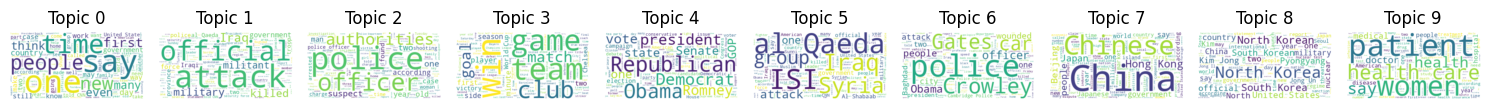

In [19]:
topics = np.argmax(svd_model.transform(X), axis=1)
num_topics = len(np.unique(topics))

docs_idxs_per_topic = [np.where(topics == i)[0] for i in range(num_topics)]

fig, axs = plt.subplots(1, num_topics, figsize=(15, 15))
for ax,j in zip(axs.flatten(),range(num_topics)):
    topic_docs = " ".join([docs[i] for i in docs_idxs_per_topic[j]])
    wc = WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Topic {j}")
    ax.axis("off")
fig.tight_layout()
fig.show()

In [20]:
#@title Implementación coherencia `u_mass`

import math

def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [21]:
get_average_topic_coherence(X, svd_model.components_, 10)

-54.7551014366205

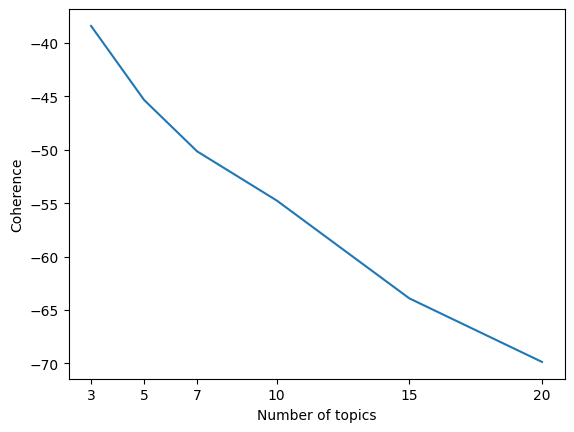

In [22]:
import matplotlib.pyplot as plt

num_topics = [3,5,7,10,15,20]
coherences = []

for k in num_topics:
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized',
                         n_iter=100, random_state=122)
    svd_model.fit(X)
    coherences.append(get_average_topic_coherence(X, svd_model.components_, 10))

plt.figure()
plt.plot(num_topics, coherences)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.xticks(num_topics)
plt.show()

## [LDA](https://radimrehurek.com/gensim/models/ldamodel.html) con gensim

Para usar la implementación de LDA de gensim necesitamos un diccionario relacionando los índices de las palabras y las palabras. Esta información ya la tenemos con el vectorizador TF-IDF.

El atributo `vocabulary_` de la clase `TfidfVectorizer` es un diccionario de la forma
            
        word: word_index

In [ ]:
vectorizer.vocabulary_

Para el modelo LDA de gensim necesitamos especificar un diccionario de la forma
            
        word_index: word

In [ ]:
dicc = dict(zip(vectorizer.vocabulary_.values(),vectorizer.vocabulary_.keys()))

Necesitamos también especificar una matriz sparse de scipy.

In [ ]:
from scipy.sparse import csr_matrix

X_csc = csr_matrix(X)

In [ ]:
%%time

from gensim.matutils import Sparse2Corpus

lda_model = models.LdaModel(corpus=Sparse2Corpus(X_csc,documents_columns=False), num_topics=10, id2word=dicc, random_state=1)

In [ ]:
lda_model.get_topics().shape

In [ ]:
word_id = 784

word_topics = lda_model.get_term_topics(word_id=word_id,minimum_probability=0)
word_topics = sorted(word_topics,key=lambda x: x[1], reverse=True)
print(f"Word: {dicc[word_id]}")
print(f"Topics: {word_topics}")

In [ ]:
lda_model.print_topics()

Podemos inspeccionar más a detalle un tópico

In [ ]:
lda_model.show_topic(topicid=9, topn=15)

In [ ]:
word = 'team'
word_id = vectorizer.vocabulary_[word]

word_topics = lda_model.get_term_topics(word_id=word_id,minimum_probability=0)
word_topics = sorted(word_topics,key=lambda x: x[1], reverse=True)
print(f"Word: {word}")
print(f"Topics: {word_topics}")

In [ ]:
lda_model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

In [ ]:
from gensim.corpora import Dictionary

dictionary = Dictionary.from_corpus(Sparse2Corpus(X_csc,documents_columns=False), id2word=dicc)
bow = dictionary.doc2bow(tokenized_docs[0])

topics = lda_model.get_document_topics(bow=bow, minimum_probability=None)

print(topics)

Veamos los tópicos de todos los documentos

In [ ]:
topics_list = []

for doc in tokenized_docs:
    bow = dictionary.doc2bow(doc)
    topics = lda_model.get_document_topics(bow=bow, minimum_probability=None)
    topics = sorted(topics,key=lambda x: x[1], reverse=True)
    topics_list.append(topics[0])

print(topics_list[:10])

In [ ]:
topics = np.array([x[0] for x in topics_list])
num_topics = len(np.unique(topics))

docs_idxs_per_topic = [np.where(topics == i)[0] for i in range(num_topics)]

fig, axs = plt.subplots(1, num_topics, figsize=(15, 15))
for ax,j in zip(axs.flatten(),range(num_topics)):
    topic_docs = " ".join([docs[i] for i in docs_idxs_per_topic[j]])
    wc = WordCloud(background_color="white", max_words=2000).generate(topic_docs)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Topic {j}")
    ax.axis("off")
fig.tight_layout()
fig.show()

Evaluación

La coherencia mide la distancia relativa entre palabras dentro de un tópico. Hay dos tipos principales:
* `c_v` típicamente está en $0 < x < 1$.
* `u_mass` típicamente es negativo.

Valores más altos son mejores.

The coherence of a topic is regarded as the sum of pairwise distributional similarity scores over the set of topic words, V:

$$\text{coh}(V) = \sum_{v_i,v_j \in V} \text{score}(v_i,v_j,ɛ).$$

* `uci` es extrínseca, los conteos se hacen en corpus externos.
$$\text{score}(v_i,v_j,ɛ) = \log\frac{p(w_i,w_j) + ɛ}{p(w_i)p(w_j)}$$

* `u_mass` en intrínseca, los conteos se hacen en corpus internos y no es simétrica.
$$\text{score}(v_i,v_j,ɛ) = \log\frac{D(w_i,w_j) + ɛ}{D(w_i)}$$

$D(w_i)$ es el número de documentos donde aparece la palabra $w_i$.

Referencias: [artículo original coherencia UMASS](https://aclanthology.org/D11-1024.pdf), [artículo comparando UMASS & UCI](https://aclanthology.org/D12-1087.pdf), [discusión en github](https://github.com/piskvorky/gensim/pull/710#issuecomment-425344644), [otra referencia](https://qpleple.com/topic-coherence-to-evaluate-topic-models/).

Estás medidas de coherencia están implementadas en `gensim`.

In [ ]:
cm = CoherenceModel(model=lda_model,
                    coherence='u_mass',
                    corpus=Sparse2Corpus(X_csc,documents_columns=False),
                    )
coherence = cm.get_coherence()
coherence

Si queremos usar las estrategias: `c_v`, `c_uci`, `c_npmi` tenemos que proporcionar información del corpus.

In [ ]:
from gensim.corpora import Dictionary

dictionary = Dictionary.from_corpus(Sparse2Corpus(X_csc,documents_columns=False), id2word=dicc)

cm = CoherenceModel(model=lda_model,
                    corpus=Sparse2Corpus(X_csc,documents_columns=False),
                    coherence='c_v',
                    texts=tokenized_docs,
                    dictionary=dictionary)
coherence = cm.get_coherence()
coherence

También podemos ver la coherencia por tópico:

In [ ]:
cm.get_coherence_per_topic()

Podemos decidir el número de tópicos en función del valor de coherencia

In [ ]:
num_topics = [3+k for k in range(15)]
coherences = []

for k in num_topics:
    lda_model = models.LdaModel(corpus=Sparse2Corpus(X_csc,documents_columns=False),
                                num_topics=k, id2word=dicc, random_state=1)
    cm = CoherenceModel(model=lda_model,
                    coherence='u_mass',
                    corpus=Sparse2Corpus(X_csc,documents_columns=False),
                    )
    coherences.append(cm.get_coherence())

In [ ]:
plt.figure()
plt.plot(num_topics, coherences)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.xticks(num_topics)
plt.show()

# 🟥 Tarea

Considera el siguiente corpus

In [23]:
!gdown 19Kp2DpVtPVe4kDN7yhNwlquiteUfqaFP

Downloading...
From: https://drive.google.com/uc?id=19Kp2DpVtPVe4kDN7yhNwlquiteUfqaFP
To: /content/topic_modelling_dataset.csv
100% 9.11M/9.11M [00:00<00:00, 106MB/s]


In [24]:
import pandas as pd

tm_df = pd.read_csv('topic_modelling_dataset.csv')
tm_df

,text
0,I ordered online while starting a movie at hom...
1,\nMark Ira Kaufman writes\n> It is your resp...
2,Horrible customer service. 2nd time in a row. ...
3,"\nSource: ""Adventures in the Near East"" by A. ..."
4,"Wow, I've never eaten here, but after the Phil..."
...,...
5997,\nhm@cs.brown.edu writes:\n> In article <1993...
5998,"called to find out the status of our order, as..."
5999,"\ndo not, and i repeat, do not, cross post the..."
6000,Message-ID: <lust29INN6e4@pageboy.cs.utexas.ed...
